In [171]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from wordcloud import WordCloud
from sklearn.decomposition import PCA
from collections import Counter

from sqlalchemy import create_engine
from urllib.parse import quote

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')

In [173]:
# Define connection parameters
server = 'localhost'
database = 'BritishAirwaysDB'
driver = 'ODBC Driver 17 for SQL Server'

# Connection string
connection_string = f"mssql+pyodbc:///?odbc_connect={quote(f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;')}"

try:
    # Establish a connection using pyodbc
    connection = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
    print("Connected successfully to the database.")

    # Execute a simple query to ensure everything is working
    cursor = connection.cursor()
    cursor.execute("SELECT @@version;")
    row = cursor.fetchone()
    if row:
        print("Database version:", row[0])

except pyodbc.Error as e:
    print("Error in connection:", e)

finally:
    # Close the connection when established
    if 'connection' in locals() and connection:
        connection.close()

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Query the table
query = "SELECT * FROM MLData"
OpenFile = pd.read_sql(query, engine)


Connected successfully to the database.
Database version: Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) 
	Oct  8 2022 05:58:25 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows 10 Home Single Language 10.0 <X64> (Build 26100: ) (Hypervisor)



In [177]:
# Data Understanding

In [179]:

# Show First ten
OpenFile = OpenFile
FirstTen = OpenFile.head(4)
FirstTen

,FlightID,Origin,Destination,Routes,DateFlown,TravellerType,SeatType,SeatComfort,CabinStaffService,FoodAndBeverages,InflightEntertainment,GroundService,ValueForMoney,RecommendedService,ReviewTitle,Review,RatingValue
0,334,Monrovia,Washington,Monrovia to Washington via Addas Ababa,2025-01-01,Couple Leisure,Economy Class,1.0,3.0,1.0,0.0,2.0,2.0,no,Not the best customer service,✅ Trip Verified | Not the best customer serv...,1.0
1,55,Addis Ababa,Toronto,Addis Ababa to Toronto via Rome,2025-01-01,Business,Business Class,2.0,1.0,1.0,1.0,2.0,3.0,no,Worst business class experience,✅ Trip Verified | Worst business class experie...,2.0
2,49,Addis Ababa,Nairobi,Addis Ababa to Nairobi,2024-12-01,Business,Economy Class,1.0,1.0,3.0,0.0,3.0,3.0,no,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,3.0
3,178,Dubai,Zanzibar,Dubai to Zanzibar via Ethiopia,2024-12-01,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,no,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,1.0


In [182]:
dataInsight = OpenFile
print(dataInsight.describe())

         FlightID  SeatComfort  CabinStaffService  FoodAndBeverages  \
count  432.000000   432.000000         432.000000        432.000000   
mean   214.312500     2.611111           2.800926          2.400463   
std    122.451911     1.505340           1.669210          1.617566   
min      1.000000     0.000000           0.000000          0.000000   
25%    108.750000     1.000000           1.000000          1.000000   
50%    216.500000     3.000000           3.000000          2.000000   
75%    318.250000     4.000000           4.000000          4.000000   
max    426.000000     5.000000           5.000000          5.000000   

       InflightEntertainment  GroundService  ValueForMoney  RatingValue  
count             432.000000     432.000000     432.000000   432.000000  
mean                1.965278       2.261574       2.726852     4.185185  
std                 1.623836       1.516684       1.591573     3.248839  
min                 0.000000       0.000000       1.000000     1

In [185]:
print(dataInsight.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FlightID               432 non-null    int64  
 1   Origin                 432 non-null    object 
 2   Destination            432 non-null    object 
 3   Routes                 432 non-null    object 
 4   DateFlown              432 non-null    object 
 5   TravellerType          432 non-null    object 
 6   SeatType               432 non-null    object 
 7   SeatComfort            432 non-null    float64
 8   CabinStaffService      432 non-null    float64
 9   FoodAndBeverages       432 non-null    float64
 10  InflightEntertainment  432 non-null    float64
 11  GroundService          432 non-null    float64
 12  ValueForMoney          432 non-null    float64
 13  RecommendedService     432 non-null    object 
 14  ReviewTitle            432 non-null    object 
 15  Review

In [188]:
#Check for Missing Values

In [190]:
data = dataInsight

# Check for missing values
print(data.isnull().sum())


FlightID                 0
Origin                   0
Destination              0
Routes                   0
DateFlown                0
TravellerType            0
SeatType                 0
SeatComfort              0
CabinStaffService        0
FoodAndBeverages         0
InflightEntertainment    0
GroundService            0
ValueForMoney            0
RecommendedService       0
ReviewTitle              0
Review                   0
RatingValue              0
dtype: int64


In [193]:
# Check for duplicates
print(data.duplicated().sum())

0


In [196]:
# Check data types
print(data.dtypes)

FlightID                   int64
Origin                    object
Destination               object
Routes                    object
DateFlown                 object
TravellerType             object
SeatType                  object
SeatComfort              float64
CabinStaffService        float64
FoodAndBeverages         float64
InflightEntertainment    float64
GroundService            float64
ValueForMoney            float64
RecommendedService        object
ReviewTitle               object
Review                    object
RatingValue              float64
dtype: object


In [199]:
# Check for unexpected categories
print(data['SeatType'].unique())
print(data['TravellerType'].unique())
print(data['RecommendedService'].unique())

['Economy Class' 'Business Class' 'Premium Economy' 'First Class']
['Couple Leisure' 'Business' 'Solo Leisure' 'Family Leisure']
['no' 'yes']


In [202]:
#Check Date format

In [204]:
# Define date format
expected_format = '%Y-%m-%d'

# check date format
def check_date_format(date_value):
    try:
        pd.to_datetime(date_value, format=expected_format)
        return True
    except ValueError:
        return False

# Apply the function to the 'DateFlown' column
dateCheck = data['DateFlown']
dateCheck = data['DateFlown'].apply(check_date_format)

# Display the results
print(dateCheck)


# Get the counts of correct and incorrect formats
correct_count = dateCheck.sum()
incorrect_count = len(dateCheck) - correct_count

print(f'Dates in correct format: {correct_count}')
print(f'Dates in incorrect format: {incorrect_count}')

# print the rows with incorrect formats
print(dateCheck[dateCheck == False])

0      True
1      True
2      True
3      True
4      True
       ... 
427    True
428    True
429    True
430    True
431    True
Name: DateFlown, Length: 432, dtype: bool
Dates in correct format: 432
Dates in incorrect format: 0
Series([], Name: DateFlown, dtype: bool)


In [208]:
# Detect Outliers

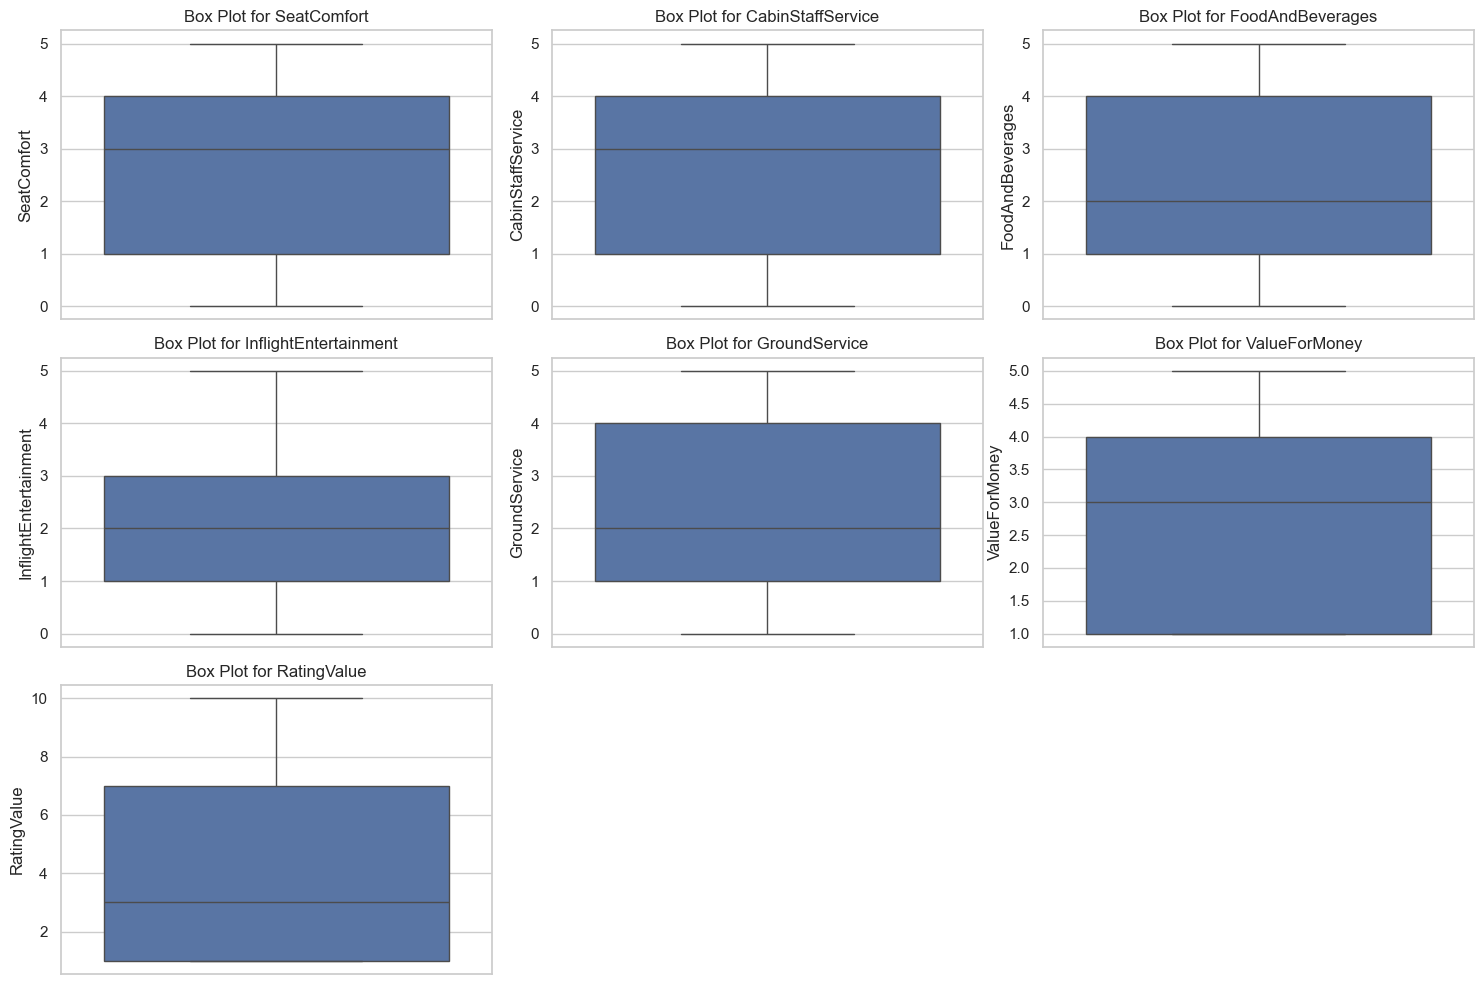

In [210]:

# box plots for numerical columns
numerical_columns = ['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 
                     'InflightEntertainment', 'GroundService', 'ValueForMoney', 
                     'RatingValue']

# Plots
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

In [213]:
# Data Cleaning

In [220]:
# Initialize OneHotEncoder

label_encoder = LabelEncoder()
data['RecommendedService'] = label_encoder.fit_transform(data['RecommendedService'])
data.head(10)


,FlightID,Origin,Destination,Routes,DateFlown,TravellerType,SeatType,SeatComfort,CabinStaffService,FoodAndBeverages,InflightEntertainment,GroundService,ValueForMoney,RecommendedService,ReviewTitle,Review,RatingValue
0,334,Monrovia,Washington,Monrovia to Washington via Addas Ababa,2025-01-01,Couple Leisure,Economy Class,1.0,3.0,1.0,0.0,2.0,2.0,0,Not the best customer service,✅ Trip Verified | Not the best customer serv...,1.0
1,55,Addis Ababa,Toronto,Addis Ababa to Toronto via Rome,2025-01-01,Business,Business Class,2.0,1.0,1.0,1.0,2.0,3.0,0,Worst business class experience,✅ Trip Verified | Worst business class experie...,2.0
2,49,Addis Ababa,Nairobi,Addis Ababa to Nairobi,2024-12-01,Business,Economy Class,1.0,1.0,3.0,0.0,3.0,3.0,0,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,3.0
3,178,Dubai,Zanzibar,Dubai to Zanzibar via Ethiopia,2024-12-01,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,1.0
4,205,Harar,Addis Ababa,Harar to Addis Ababa,2024-08-01,Solo Leisure,Economy Class,3.0,4.0,2.0,1.0,2.0,2.0,0,airline is NEVER on time,Not Verified | This airline is NEVER on time. ...,3.0
5,312,London,Nairobi,London to Nairobi via Addis Ababa,2024-07-01,Solo Leisure,Premium Economy,3.0,1.0,1.0,1.0,1.0,1.0,0,did not load my luggage,Not Verified | They did not load my luggage de...,2.0
6,424,Washington IAD,Johannesburg,Washington IAD to Johannesburg,2024-12-01,Couple Leisure,Economy Class,2.0,2.0,1.0,3.0,1.0,1.0,0,service fell painfully short,✅ Trip Verified | My recent journey from Was...,3.0
7,59,Addis Ababa,Washington,Addis Ababa to Washington via Lome,2024-11-01,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,2.0,1.0,0,Ethiopian Airlines needs to do better,✅ Trip Verified | I just landed from an Ethi...,1.0
8,129,Cape Town,Gatwick,Cape Town to Gatwick via Addis Ababa,2024-07-01,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0,they won't respond,✅ Trip Verified | On their website they claim...,1.0
9,266,Lagos,Addis Ababa,Lagos to Addis Ababa,2024-03-01,Business,Economy Class,4.0,5.0,5.0,4.0,5.0,4.0,1,express my heartfelt appreciation,✅ Trip Verified | I would like to express my ...,9.0


In [218]:
print(data['RecommendedService'].unique())

[0 1]


In [ ]:
# MODELING - Sentiment Analysis

In [228]:
# Initialize the sentiment analyze
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis to reviews column to read emotions
data['Sentiment'] = data['Review'].apply(lambda x: sid.polarity_scores(x)['compound'])


# we now Categorize our sentiment into positive, negative, and neutral
def categorizeSentiment(score):
   if score >= 0.05:
       return 'Positive'
   elif score <= -0.05:
       return 'Negative'
   else:
       return 'Neutral'

data['Sentiment_Label'] = data['Sentiment'].apply(categorizeSentiment)


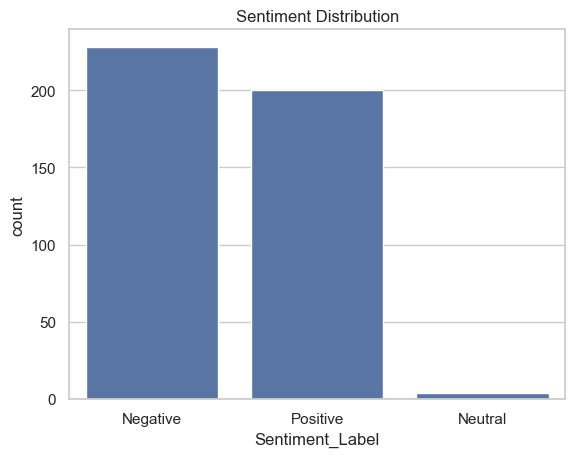

In [230]:
# Visualize Sentiment Distribution:
sns.countplot(x='Sentiment_Label', data=data)
plt.title('Sentiment Distribution')
plt.show()

In [234]:
# analyze how sentiment correlates with these Rating variables
sentiment_analysis = data.groupby('Sentiment_Label')['RatingValue'].mean()
print(sentiment_analysis)

Sentiment_Label
Negative    2.232456
Neutral     2.250000
Positive    6.450000
Name: RatingValue, dtype: float64


In [ ]:
# Results

# Negative: Average rating of 2.23, indicating that negative reviews likely contain more criticisms than positive comments.
# Neutral: Average rating of 2.25, suggesting that neutral reviews often have mixed or average experiences without strong opinions for or against the product.
# Positive: Average rating of 6.45, showing a high level of satisfaction among users who provided positive reviews.

In [236]:
# Map (0-10) our ratings to a descriptive format
def categorize_rating(score):
   if score >= 8:
       return 'Excellent'
   elif score >= 5:
       return 'Good'
   elif score >= 3:
       return 'Fair'
   else:
       return 'Poor'

data['Rating_Label'] = data['RatingValue'].apply(categorize_rating)


# Analyze correlation between sentiment labels and ratings
correlation_analysis = data.groupby(['Sentiment_Label', 'Rating_Label'])['RatingValue'].mean().unstack()
print(correlation_analysis)

Rating_Label     Excellent      Fair      Good      Poor
Sentiment_Label                                         
Negative          8.600000  3.377778  5.578947  1.308176
Neutral                NaN       NaN  5.000000  1.333333
Positive          9.103093  3.380952  6.276596  1.171429


In [ ]:
# #Results:

# 1. Negative Sentiment: 
# Excellent: The High average rating of 8.6 this indicates that some negative reviews still came from users who gave high ratings, which might suggest mixed feelings.
# Good: A moderate average of 5.58, this indicates that many good-rated reviews could contain minor criticisms.
# Fair: Lower average score of 3.38, this indicates that the reviews that were rated as "fair" likely received more negative sentiments.
# Poor: A very low average of 1.31 shows that negative sentiment is strongly associated with the lowest ratings.


# 2. Neutral Sentiment: 
# Results shows that only "Good" has a defined average of 5.0, while other categories are NaN, indicating that there may not be enough data points, suggesting neutral reviews often correspond with a "Good" rating, aligning with an average experience.

# 3. Positive Sentiment:
# Excellent: The highest average rating of 9.10, showing satisfaction with positive sentiment.
# Good: Reasonable average of 6.28, indicating many positive reviews gave decent, but not top-tier ratings.
# Fair: Lower score of 3.38 this indicates that even positive sentiments could have some reservations.
# Poor: The lowest score of 1.17 this indicates that positive sentiment is generally not associated with very low ratings.


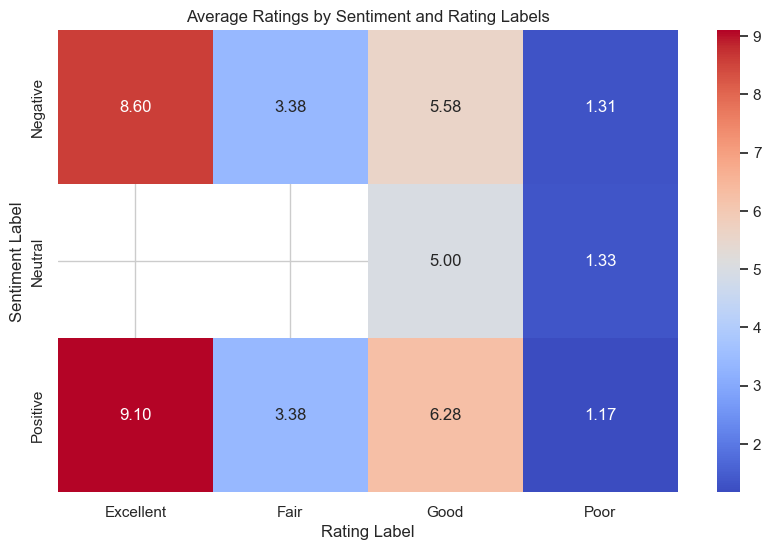

In [238]:

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_analysis, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Ratings by Sentiment and Rating Labels')
plt.ylabel('Sentiment Label')
plt.xlabel('Rating Label')
plt.show()

In [ ]:
# Prepare Data for Predictive Modeling

In [270]:
X = data[['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney']]
y = data['RecommendedService']

In [272]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [275]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
data['PredictedRecommendation'] = model.predict(X)

In [278]:
# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.3f}")


Model Accuracy: 0.931


In [280]:
# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluate result using precision, recall, F1-score
from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")

Confusion Matrix:
[[45  4]
 [ 2 36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.90      0.95      0.92        38

    accuracy                           0.93        87
   macro avg       0.93      0.93      0.93        87
weighted avg       0.93      0.93      0.93        87

Precision: 0.900
Recall: 0.947
F1-Score: 0.923


In [ ]:
# Hyperparameter Tuning

In [284]:
# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [313]:
model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV with cross-validation
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train2, y_train2)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 50],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='accuracy')

In [303]:

# Best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train our best model
best_model = grid_search.best_estimator_
data['PredictedRecommendation2'] = best_model.predict(X)


accuracy2 = best_model.score(X_test2, y_test2)
print(f"Model Accuracy: {accuracy2:.3f}")


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Model Accuracy: 0.943


In [305]:
# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
y_pred2 = best_model.predict(X_test2)
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))

from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Precision: {precision_score(y_test2, y_pred2):.3f}")
print(f"Recall: {recall_score(y_test2, y_pred2):.3f}")
print(f"F1-Score: {f1_score(y_test2, y_pred2):.3f}")

Confusion Matrix:
[[45  4]
 [ 1 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        49
           1       0.90      0.97      0.94        38

    accuracy                           0.94        87
   macro avg       0.94      0.95      0.94        87
weighted avg       0.95      0.94      0.94        87

Precision: 0.902
Recall: 0.974
F1-Score: 0.937


In [319]:
X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)

# Create a Neural Network model
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Our Input layer
    layers.Dense(32, activation='relu'),                                   # Hidden layer
    layers.Dense(1, activation='sigmoid')                                  # Output layer for binary classification
])

model_nn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = model_nn.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val))

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
C:\Users\osen1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5124 - loss: 0.6415 - val_accuracy: 0.7536 - val_loss: 0.6429
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8172 - loss: 0.5786 - val_accuracy: 0.8261 - val_loss: 0.5590
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9145 - loss: 0.4969 - val_accuracy: 0.8551 - val_loss: 0.4940
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8764 - loss: 0.4417 - val_accuracy: 0.8696 - val_loss: 0.4471
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9038 - loss: 0.3761 - val_accuracy: 0.8841 - val_loss: 0.4097
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9054 - loss: 0.3223 - val_accuracy: 0.8841 - val_loss: 0.3862
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9332 - loss: 0.2723 - val_accuracy: 0.8841 - val_loss: 0.3803
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 0.2673 - val_accuracy: 0.8841 - val_loss

In [321]:
y_pred_nn = (model_nn.predict(X_test2) > 0.5).astype("int32")

# Confusion Matrix
print(confusion_matrix(y_test2, y_pred_nn))
print(classification_report(y_test2, y_pred_nn))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[45  4]
 [ 2 36]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.90      0.95      0.92        38

    accuracy                           0.93        87
   macro avg       0.93      0.93      0.93        87
weighted avg       0.93      0.93      0.93        87

